In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import glob

file_dir = '/Users/bhupendra/projects/bnf-amf3/data/bnfldquantsM1.c1/' 
file_pattern = 'bnfldquantsM1.c1.2025*.nc' 
file_paths = sorted(glob.glob(file_dir + file_pattern)) 

print(len(file_paths))

39


I will use xarray to read mutiple files

In [4]:
ds = xr.open_mfdataset(file_paths, combine='by_coords')
print(ds) 

<xarray.Dataset> Size: 10MB
Dimensions:                                      (time: 54412)
Coordinates:
  * time                                         (time) datetime64[ns] 435kB ...
Data variables: (12/42)
    base_time                                    (time) datetime64[ns] 435kB ...
    time_offset                                  (time) datetime64[ns] 435kB dask.array<chunksize=(1440,), meta=np.ndarray>
    rain_rate                                    (time) float32 218kB dask.array<chunksize=(1440,), meta=np.ndarray>
    reflectivity_factor_sband20c                 (time) float32 218kB dask.array<chunksize=(1440,), meta=np.ndarray>
    reflectivity_factor_cband20c                 (time) float32 218kB dask.array<chunksize=(1440,), meta=np.ndarray>
    reflectivity_factor_xband20c                 (time) float32 218kB dask.array<chunksize=(1440,), meta=np.ndarray>
    ...                                           ...
    specific_differential_attenuation_cband20c   (time) float32 

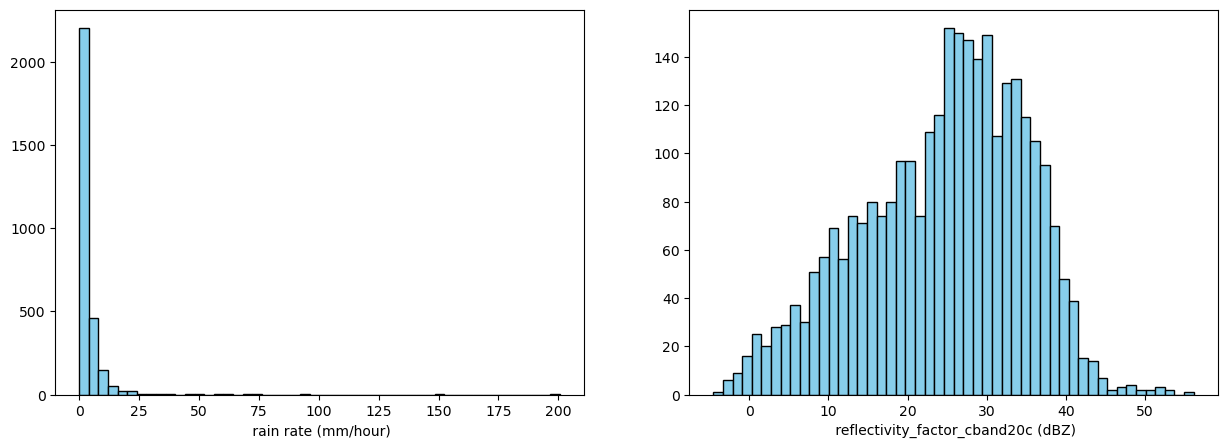

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 

ds['rain_rate'].plot.hist(ax=axes[0], bins=50, color='skyblue', edgecolor='black')
axes[0].set_xlabel(f' {'rain rate'} ({ds['rain_rate'].units})')

ds['reflectivity_factor_cband20c'].plot.hist(ax=axes[1], bins=50, color='skyblue', edgecolor='black')
axes[1].set_xlabel(f' {'reflectivity_factor_cband20c'} ({ds['reflectivity_factor_cband20c'].units})')

plt.show()

This looks as expected. There are some higher values of rain rates.

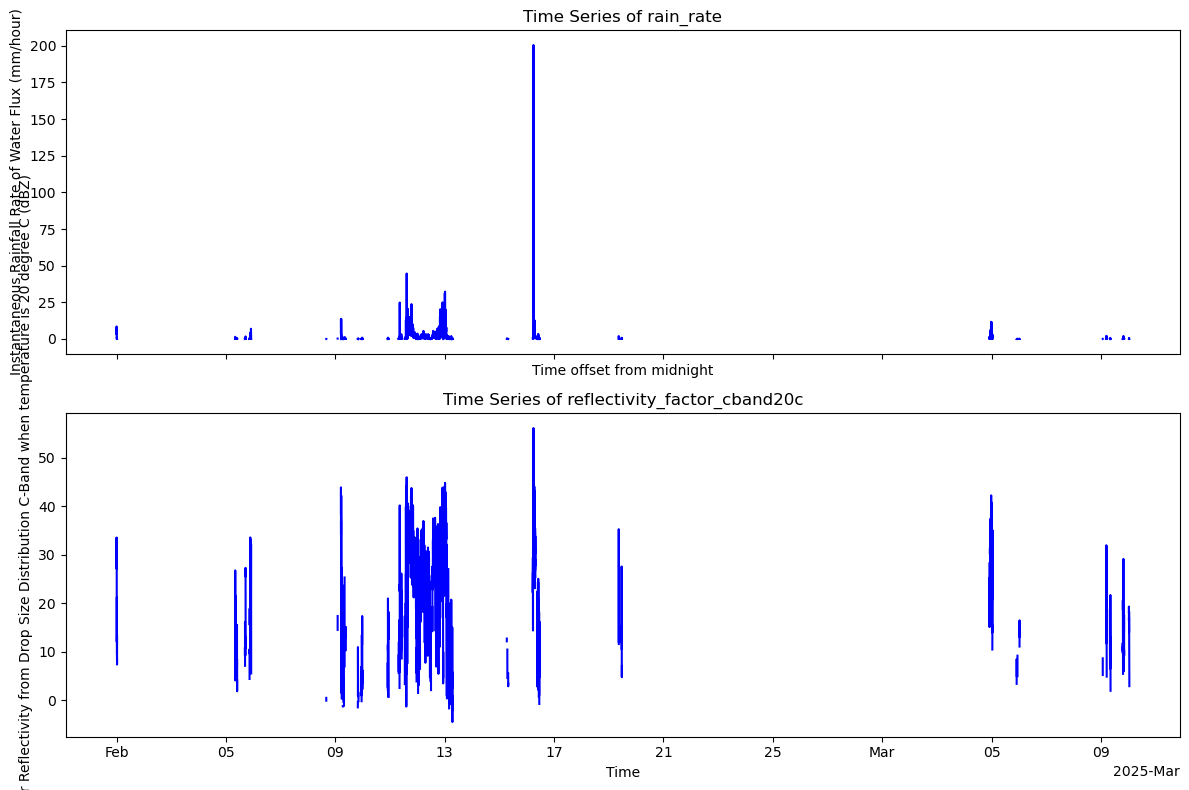

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True) 

ds['rain_rate'].plot(ax=axes[0], color='blue')
axes[0].set_title('Time Series of rain_rate')
axes[0].set_ylabel(f'{ds["rain_rate"].long_name} ({ds["rain_rate"].units})')

ds['reflectivity_factor_cband20c'].plot(ax=axes[1], color='blue')
axes[1].set_title('Time Series of reflectivity_factor_cband20c')
axes[1].set_ylabel(f'{ds["reflectivity_factor_cband20c"].long_name} ({ds["reflectivity_factor_cband20c"].units})')

plt.xlabel('Time')
plt.tight_layout()
plt.show()

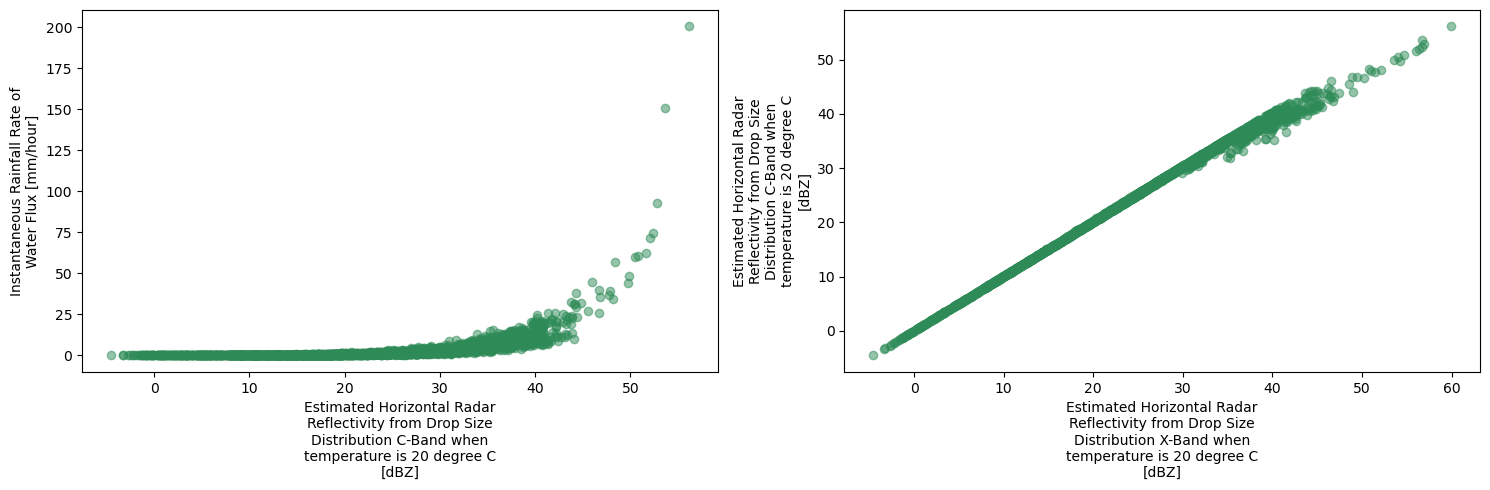

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ds.plot.scatter(x='reflectivity_factor_cband20c', y='rain_rate', ax=axes[0], alpha=0.5, color='seagreen')
ds.plot.scatter(x='reflectivity_factor_xband20c', y='reflectivity_factor_cband20c', ax=axes[1], alpha=0.5, color='seagreen')

plt.tight_layout()
plt.show()


To find the coefficients `a` and `b` in the power-law relationship `Z = a * R^b`, we do linear regression in log-log space. 
Take Log of both sides of the Z-R equation gives

log(Z) = log(a) + b * log(R)


In [8]:
# let me first remove bad values, as i think that is causing issues
rain_rate = ds['rain_rate'].values 
reflectivity_dbz = ds['reflectivity_factor_cband20c'].values

valid_indices_zr = np.where(np.isfinite(rain_rate) & np.isfinite(reflectivity_dbz) & (rain_rate > 0)) # remove bad values
rain_rate = rain_rate[valid_indices_zr]
reflectivity_dbz = reflectivity_dbz[valid_indices_zr]

In [9]:
print(f"Min dBZ: {min(reflectivity_dbz)}")
print(f"Max dBZ: {max(reflectivity_dbz)}")

Min dBZ: -4.522533893585205
Max dBZ: 56.1351432800293


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


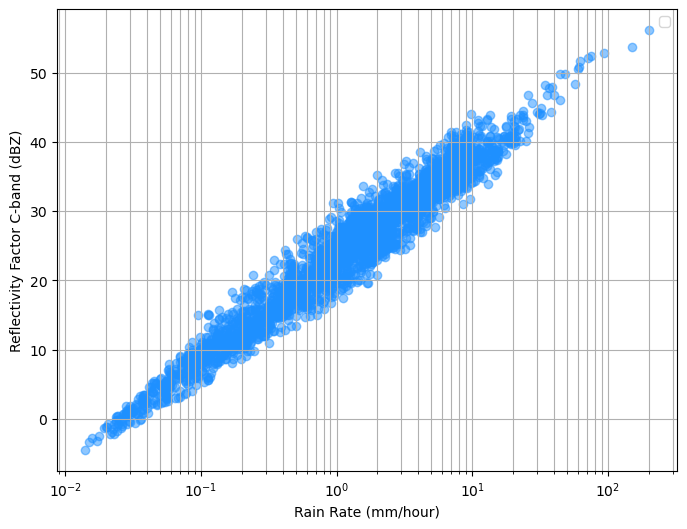

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(rain_rate, reflectivity_dbz, alpha=0.5, color='dodgerblue')
plt.xlabel('Rain Rate (mm/hour)')
plt.ylabel('Reflectivity Factor C-band (dBZ)')
plt.xscale('log') # Logarithmic scale for rain rate
plt.yscale('linear')
plt.grid(True, which="both", ls="-")
plt.legend()
plt.show()

In [11]:
log_R = np.log10(rain_rate) # Take log10 of rain rate
log_Z = reflectivity_dbz # Use dBZ directly for log-log fit 


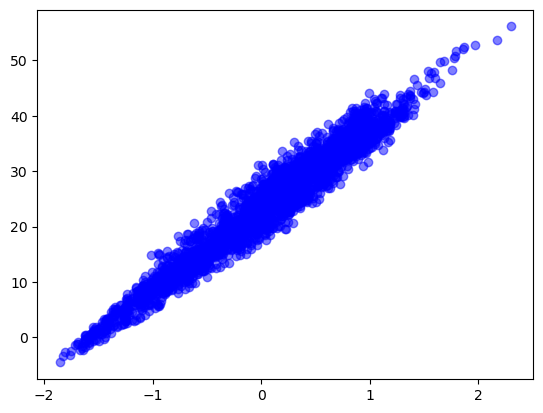

In [12]:
plt.plot(log_R, log_Z, 'o', color='blue', alpha=0.5)

In [13]:
coefficients_zr = np.polyfit(log_R, log_Z, 1) # Linear fit: log(Z) = b*log(R) + log(a)
print(f"coefficients_zr (raw from np.polyfit): {coefficients_zr}")
b_coefficient = coefficients_zr[0] # Slope
log_a_coefficient = coefficients_zr[1] # Intercept
a_coefficient = 10**log_a_coefficient # Convert to a

print(f"Z-R Relationship for C-band (from LDQUANTS data):")
print(f"Z = {a_coefficient:.2f} * R**{b_coefficient:.2f}") # Z = a * R^b

coefficients_zr (raw from np.polyfit): [14.61414582 23.31882291]
Z-R Relationship for C-band (from LDQUANTS data):
Z = 208364107262752691585024.00 * R**14.61


This does not make sense. Values are too high.
I checked tat I am not making mistake in units. I have removed bad values.
Is there anything I am missing/miss interpreting/oversight.